# Hillipop with Planck 2018 data (NPIPE release)
## Preamble

This notebook make use of [GetDist](https://getdist.readthedocs.io/en/latest/) python package to plot and to analyse MCMC samples.



In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

Print versions used



In [2]:
import getdist
import matplotlib

getdist.chains.print_load_details = False

print("     Numpy :", np.__version__)
print("Matplotlib :", matplotlib.__version__)
print("   GetDist :", getdist.__version__)

     Numpy : 1.19.2
Matplotlib : 3.3.2
   GetDist : 1.1.2


## Definitions



Define CMB & nuisance parameter names.



In [3]:
cosmo_params = ["cosmomc_theta", "logA", "ns", "ombh2", "omch2", "H0", "Alens", "tau"]
nuisance_params = [
    "Aplanck",
    "c0",
    "c1",
    "c3",
    "c4",
    "c5",
    "Aradio",
    "Adusty",
    "AdustTT",
    "AdustPP",
    "AdustTP",
    "Asz",
    "Acib",
    "Aksz",
    "Aszxcib",
]

## MCMC chains



Let's plot the chains size for all the simulations



In [4]:
import glob

nsim = 1
nchains = {i: [] for i in range(nsim)}
for i in range(nsim):
    chain_dir_tmpl = "./output/NPIPE/mcmc.?.txt"
    files = sorted(glob.glob(chain_dir_tmpl.format(i)))
    nchains[i] += [sum(1 for line in open(f)) for f in files]
    nchains[i] += [sum(nchains[i])]

from tabulate import tabulate

tabulate(
    [(k, *v) for k, v in nchains.items()],
    headers=["Sim."] + ["mcmc {}".format(i) for i in range(1, 5)] + ["total"],
    tablefmt="html",
)

Sim.,mcmc 1,mcmc 2,mcmc 3,mcmc 4,total
0,124295,125153,129030,121434,499912


Have a look at how chains evolve with time and check convergence or not.



In [5]:
def plot_chains(file_root, params, nrow=None, ncol=None):
    import glob

    files = sorted(glob.glob(file_root + ".?.txt"))

    nrow = len(params) // 2 if nrow is None else nrow
    ncol = len(params) // 2 if ncol is None else ncol
    plt.figure(figsize=(15, 10))
    ax = [plt.subplot(nrow, ncol, i + 1) for i in range(len(params))]

    # Loop over files independently
    for f in files:
        from getdist import loadMCSamples

        sample = loadMCSamples(f[:-4])
        color = "C{}".format(f.split(".")[-2])

        # Get param values
        values = sample.getParams()

        # Get associated LaTeX labels
        labels = sample.paramNames.parsWithNames(params)
        for i, p in enumerate(params):
            ax[i].set_ylabel(labels[i].latexLabel())
            ax[i].plot(getattr(values, p), alpha=0.75, color=color)
    plt.tight_layout()

Plot chains for the CMB & nuisance parameters



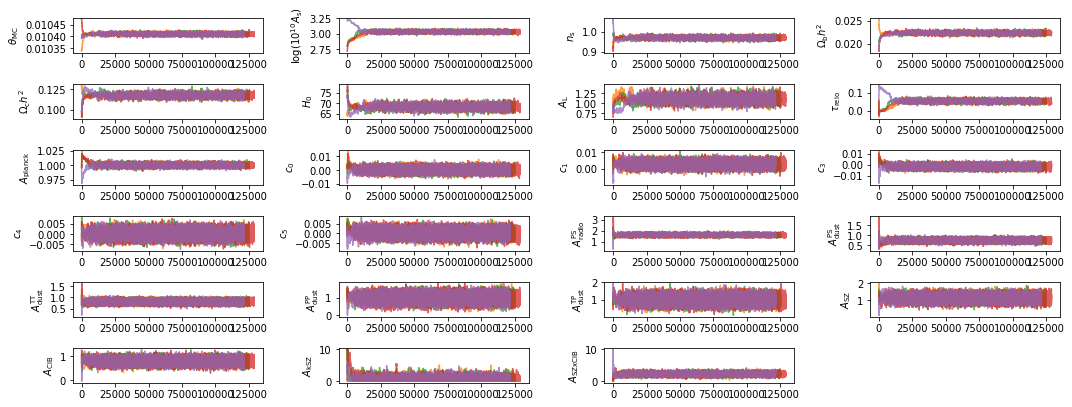

In [7]:
chains = "./output/NPIPE/mcmc"
plot_chains(chains, params=cosmo_params + nuisance_params, ncol=4)

## MCMC distributions



Define global plot settings



In [8]:
from getdist.plots import GetDistPlotSettings

plot_settings = GetDistPlotSettings()
plot_settings.num_plot_contours = 3
plot_settings.solid_colors = "tab10"
plot_settings.line_styles = "tab10"
plot_settings.legend_fontsize = 15

Load MCMC samples



In [9]:
from getdist import loadMCSamples

samples = [loadMCSamples(chains, settings={"ignore_rows": 0.4})]

Plot posteriors distributions of CMB parameters



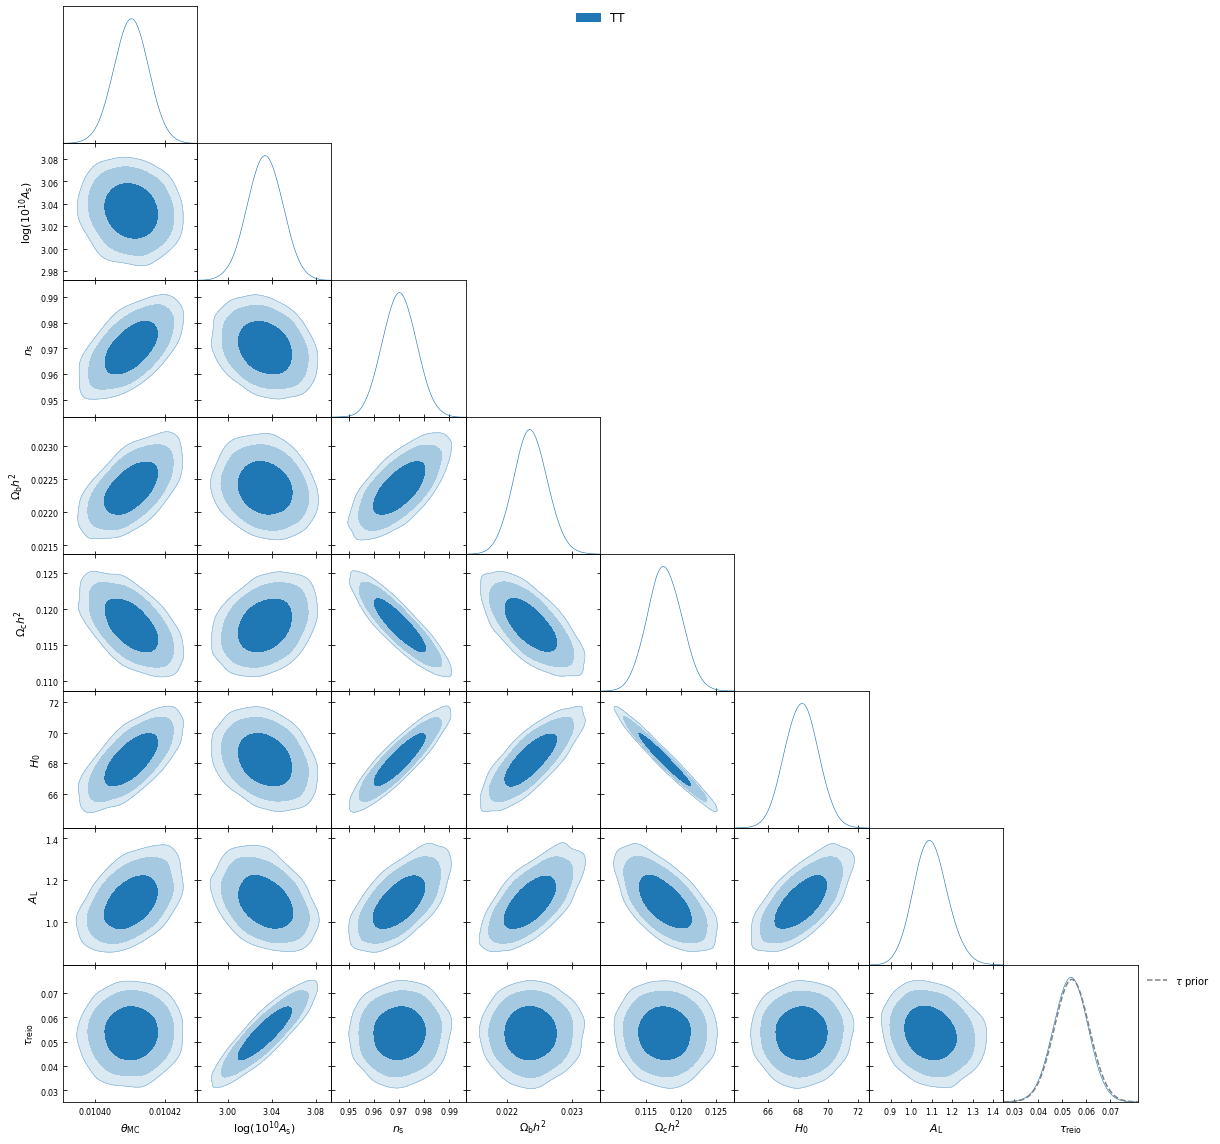

In [10]:
from getdist import plots

g = plots.get_subplot_plotter(settings=plot_settings)
colors = ["C0", "C1", "C2", "C3"]
g.triangle_plot(
    samples,
    cosmo_params,
    filled=True,
    legend_labels=["TT", "EE", "TE", "TT, TE, EE"],
    colors=colors,
    diag1d_kwargs={"colors": colors},
)
# Show prior on tau
ax = g.subplots[-1, -1]
xmin, xmax, ymin, ymax = ax.axis()
x = np.linspace(xmin, xmax, 100)
from scipy.stats import norm

ax.plot(x, 0.018 * norm.pdf(x, 0.054, 0.0073), color="gray", ls="--", label=r"$\tau$ prior")
ax.legend(loc="upper left", bbox_to_anchor=(1, 1));

Plot posteriors distributions of nuisance parameters



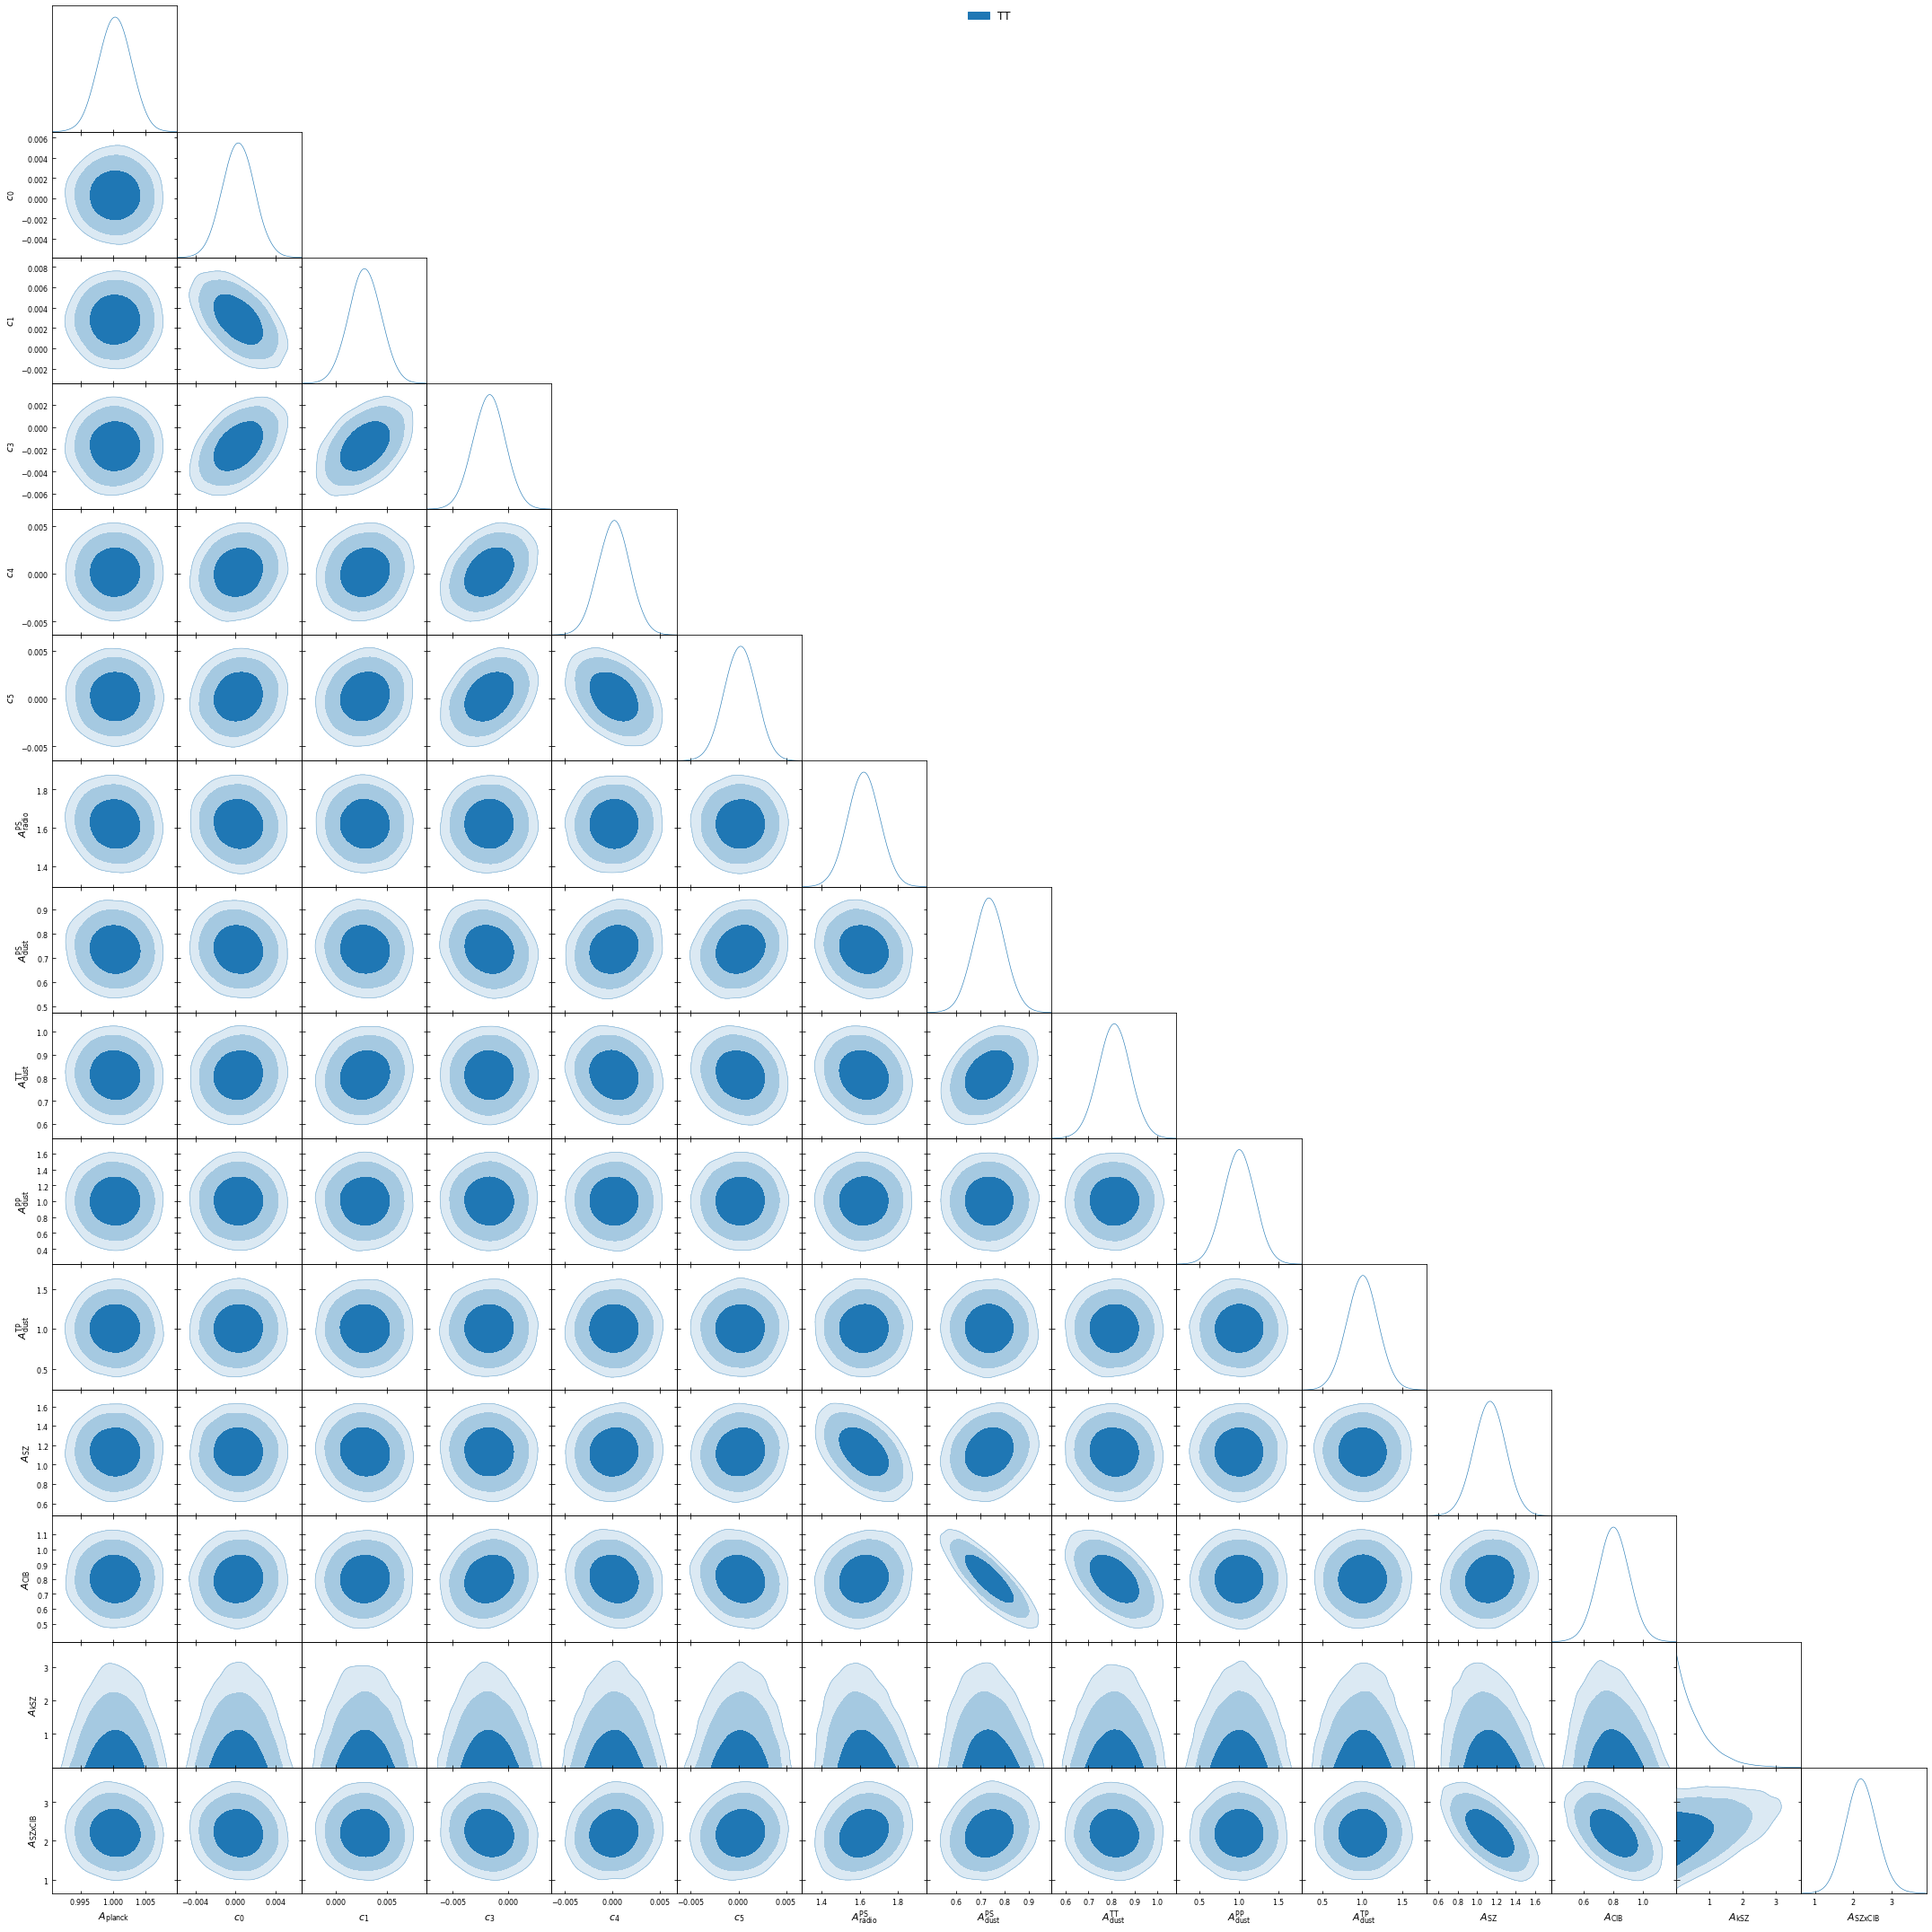

In [11]:
g.triangle_plot(
    samples,
    nuisance_params,
    filled=True,
    legend_labels=["TT", "TT, TE, EE"],
    colors=["C0", "C3"],
    diag1d_kwargs={"colors": ["C0", "C3"]},
)

### Correlation plot



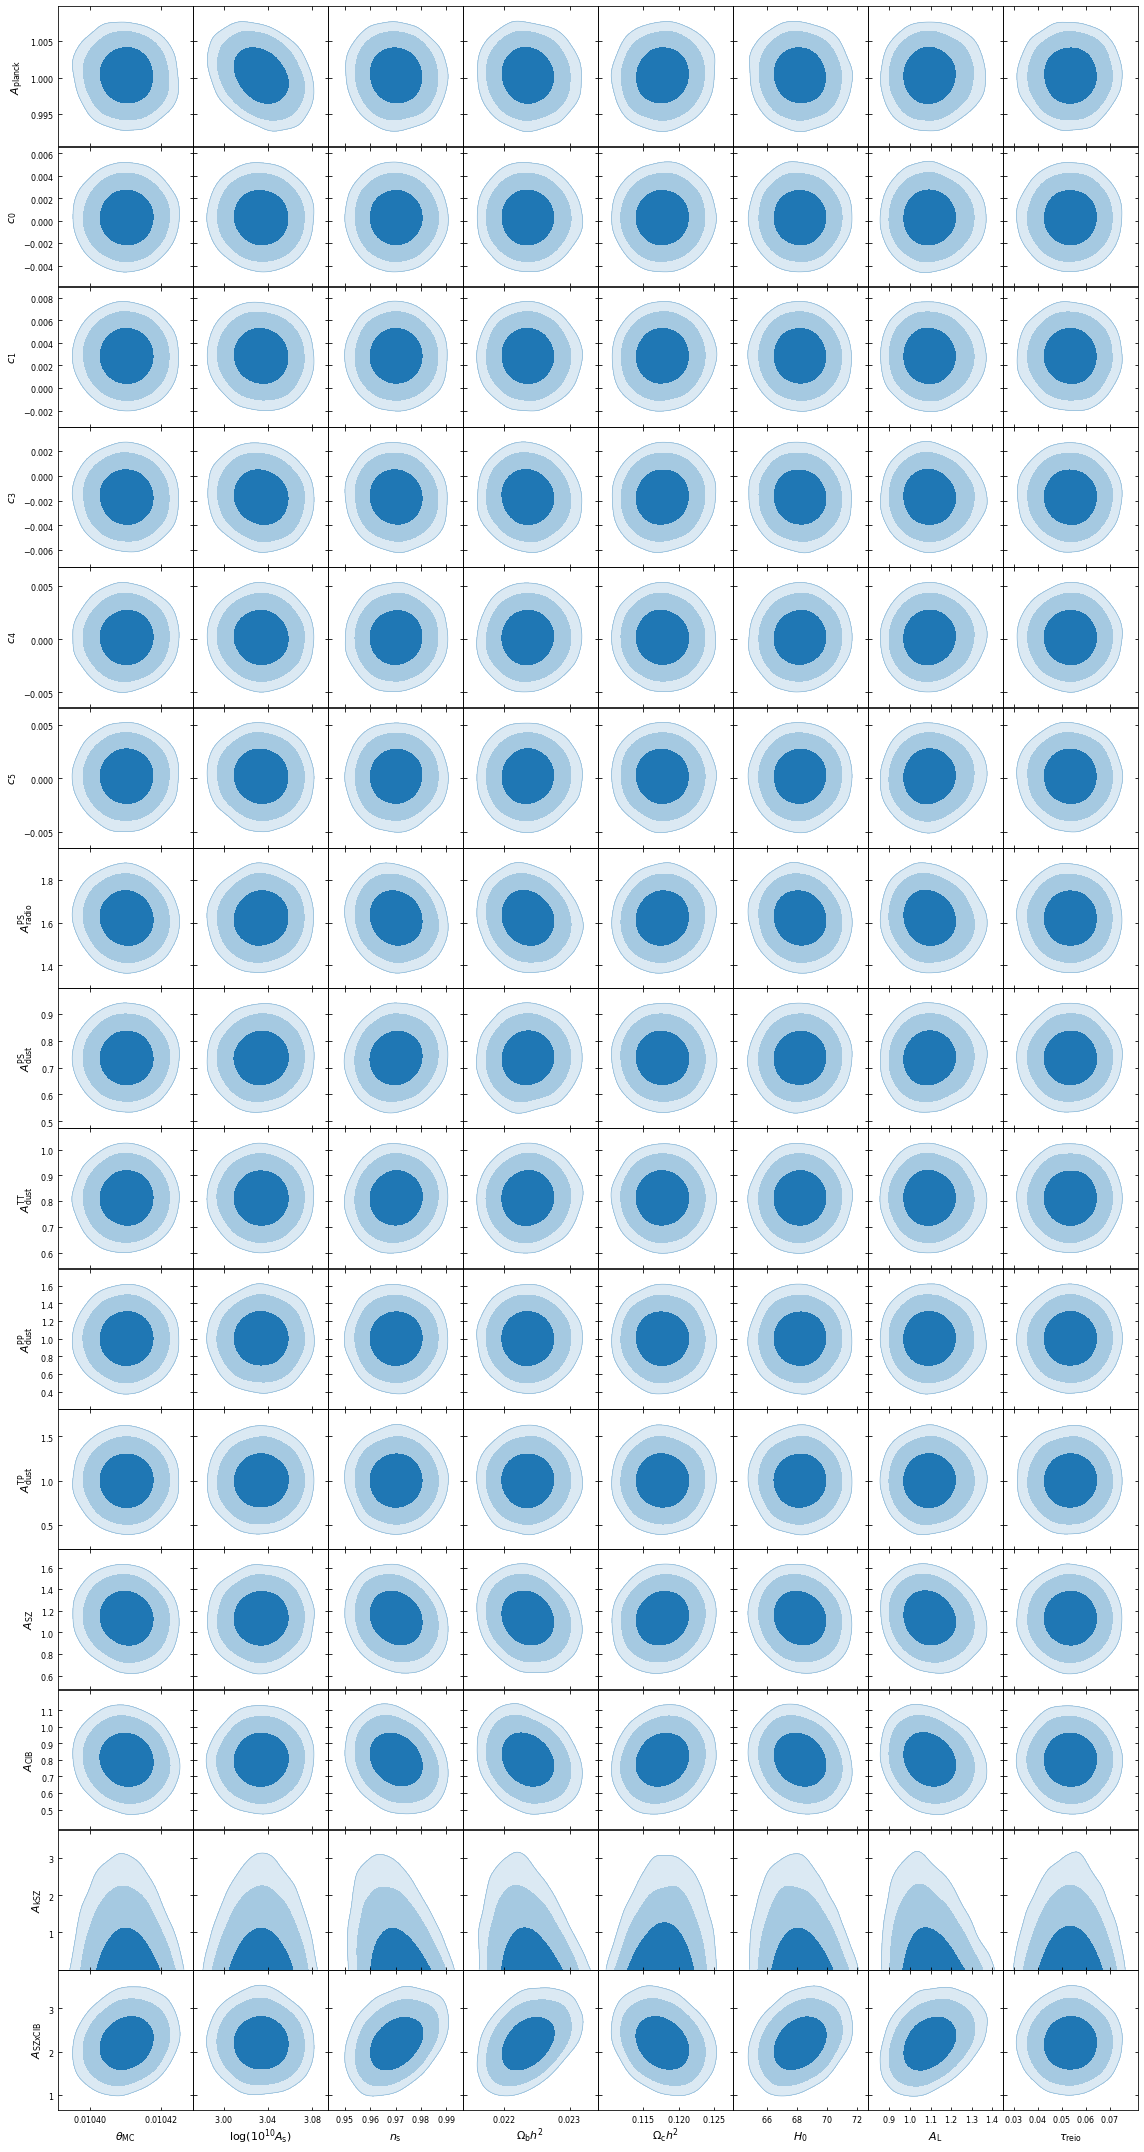

In [13]:
g.rectangle_plot(cosmo_params, nuisance_params, roots=samples, filled=True);

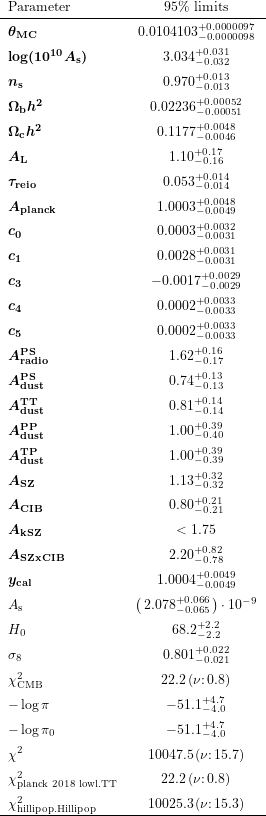

In [12]:
from IPython.display import Image

Image(samples[0].getTable().tablePNG())